In [139]:
import numpy as np
import matplotlib.pyplot as plt

In [147]:
class CosineScheduler:
    def __init__(self, t_0: float, t_f: float, s: float = 0.0):
        self.t_0 = t_0
        self.t_f = t_f
        self.s = s

    def lambda_t0(self, t):
        return 1 - np.cos(0.5 * np.pi * ((t / self.t_f) + self.s) / (1 + self.s)) ** 2

    def lambda_t(self, t1, t0):
        return 1 - np.exp(
            -np.abs(
                np.log(
                    np.cos(0.5 * np.pi * ((t1 / self.t_f) + self.s) / (1 + self.s))
                    ** 2
                )
                - np.log(
                    np.cos(0.5 * np.pi * ((t0 / self.t_f) + self.s) / (1 + self.s))
                    ** 2
                )
            )
        )

def cos_sq_fn_step_scheme(
    start, end, dt, s=0.008, dtype=np.float32, **_):
  """Exponential decay step scheme from Nichol and Dhariwal 2021.

  Args:
    start: start time defaults to 0
    end: end time defaults to 1
    dt: number of steps to divide grid into
    s: shift to ensure non 0
    dtype: for tpu support
    **_: placeholder to handle different scheme args

  Returns:
    time grid
  """
  n_steps = int((end - start) / dt)

  pre_phase = np.linspace(start, end, n_steps, dtype=dtype) / end
  phase = ((pre_phase + s) / (1 + s)) * np.pi * 0.5
  # Note this multiples small numbers however implemented it more stably
  # (removed sqrt from solver only sqrd here) and it made no difference to
  # results
  dts = np.cos(phase)**2

  dts /= dts.sum()
  dts *= end  # We normalise s.t. \sum_k \beta_k = T (where beta_k = b_m*cos^4)

  dts_out = np.concatenate((np.array([start]), np.cumsum(dts)))
  return dts_out

def cos_sq_fn_step_scheme_unnorm(
    start, end, dt, s=0.008, dtype=np.float32, **_):
  """Exponential decay step scheme from Nichol and Dhariwal 2021.

  Args:
    start: start time defaults to 0
    end: end time defaults to 1
    dt: number of steps to divide grid into
    s: shift to ensure non 0
    dtype: for tpu support
    **_: placeholder to handle different scheme args

  Returns:
    time grid
  """
  n_steps = int((end - start) / dt)

  pre_phase = np.linspace(start, end, n_steps, dtype=dtype) / end
  phase = ((pre_phase + s) / (1 + s)) * np.pi * 0.5
  # Note this multiples small numbers however implemented it more stably
  # (removed sqrt from solver only sqrd here) and it made no difference to
  # results
  dts = np.cos(phase)**2

  # dts /= dts.sum()
  # dts *= end  # We normalise s.t. \sum_k \beta_k = T (where beta_k = b_m*cos^4)

  dts_out = np.concatenate((np.array([start]), np.cumsum(dts)))
  return dts_out

0.94323924646871
0.9793364027064132
1.0


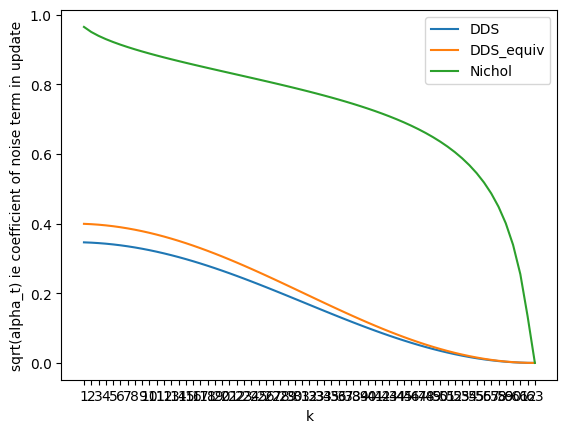

In [148]:
t0 = 0.0
t1 = 3.2
K=64
alpha = 1.075
alpha_mod = 0.4
dt = t1/K
s = 0.008

ts = cos_sq_fn_step_scheme(t0, t1, dt)[1:]
beta_k = np.clip(alpha * (ts[1:] - ts[:-1]), 0, 1)
print(1 - np.prod(1-beta_k**2))

ts = cos_sq_fn_step_scheme_unnorm(0.0, 1.0, 1.0/K)[1:]
beta_k_equiv = np.clip(alpha_mod * (ts[1:] - ts[:-1]), 0, 1)
print(1 - np.prod(1-beta_k_equiv**2))

cosine_schedule =  CosineScheduler(0.0, 1.0, s)
ts = np.linspace(0.0, 1.0, K)
beta_k_nichol = 1 - np.sqrt(cosine_schedule.lambda_t(ts[:-1], ts[1:]))
print(1 - np.prod(1-beta_k_nichol**2))

ks = np.arange(1, K)
plt.plot(ks, beta_k, label='DDS')
plt.plot(ks, beta_k_equiv, label='DDS_equiv')
plt.plot(ks, beta_k_nichol, label='Nichol')
plt.xticks(ks)
plt.legend()
plt.xlabel('k')
plt.ylabel('sqrt(alpha_t) ie coefficient of noise term in update')
plt.show()